In [1]:
from datasets import load_dataset, DatasetDict, Dataset
import json
from transformers import PerceiverTokenizer, PerceiverModel, PerceiverConfig, PerceiverPreTrainedModel, PerceiverForSequenceClassification, TrainingArguments, Trainer, \
    DataCollatorWithPadding
import re
import os
from tqdm import tqdm
import torch
ROOT_PATH = ".."
with open(os.path.join(ROOT_PATH, "ignored_dir/data/contract-nli/train.json")) as train_json_f:
    train_json = json.load(train_json_f)
id2label = {0: "Entailment", 1: "Contradiction", 2: "NotMnetioned"}
label2id = {"Entailment": 0, "Contradiction": 1, "NotMentioned": 2}

def load_dataset_custom(dataset_name):
    if dataset_name == "contract-nli":
        def contract_nli_iterator(data):
            documents, labels = data['documents'], data['labels']
            for document in documents:
                id = document['id']
                file_name = document['file_name']
                text = document['text']
                spans = document['spans']
                annotation_sets = document['annotation_sets']
                document_type = document['document_type']
                url = document['url']
                for annotation_id, annotation_content in annotation_sets[0]['annotations'].items():
                    hypothesis = labels[annotation_id]['hypothesis']
                    choice = annotation_content['choice']
                    yield {
                        "id": id,
                        "file_name": file_name,
                        "text": text,
                        "spans": spans,
                        "document_type": document_type,
                        "url": url,
                        "hypothesis": hypothesis,
                        "labels": label2id[choice],
                    }            
        base_filepath = os.path.join(ROOT_PATH, "ignored_dir/data/contract-nli")
        train_filepath = os.path.join(base_filepath, "train.json")
        validation_filepath = os.path.join(base_filepath, "dev.json")
        test_filepath = os.path.join(base_filepath, "test.json")
        with open(train_filepath) as f:
            train_data = json.load(f)
        with open(validation_filepath) as f:
            validation_data = json.load(f)
        with open(test_filepath) as f:
            test_data = json.load(f)
        data = {
            "train": Dataset.from_generator(lambda: contract_nli_iterator(train_data)),
            "validation": Dataset.from_generator(lambda: contract_nli_iterator(validation_data)),
            "test": Dataset.from_generator(lambda: contract_nli_iterator(test_data)),
        }
        return DatasetDict(data)
    return None

contract_nli_dataset = load_dataset_custom("contract-nli")

In [2]:
from datasets import load_dataset, DatasetDict, Dataset
import json
from transformers import PerceiverTokenizer, PerceiverModel, PerceiverConfig, PerceiverPreTrainedModel, PerceiverForSequenceClassification, TrainingArguments, Trainer, \
    DataCollatorWithPadding, DataCollatorForLanguageModeling, PerceiverForMaskedLM
import re
import os
from tqdm import tqdm
import torch

model_max_length = 60000 # set a big number here for now
perceiver_tokenizer = PerceiverTokenizer(model_max_length=model_max_length)
def process_contract_nli_dataset(element):
    return perceiver_tokenizer(element['text'], element['hypothesis'], truncation=True, padding="max_length")

contract_nli_dataset_processed = contract_nli_dataset.map(process_contract_nli_dataset, batched=True, remove_columns=contract_nli_dataset["train"].column_names,
)

/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
contract_nli_dataset_processed

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 7191
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1037
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 2091
    })
})

In [4]:
perceiver_config = PerceiverConfig.from_pretrained("deepmind/language-perceiver", model_max_length=model_max_length, num_labels=3, max_position_embeddings=model_max_length)
ckpt_path = "../ignored_dir/training_outputs/perceiver_mlm/run_62/checkpoint-2250"
perceiver_model = PerceiverForMaskedLM.from_pretrained("deepmind/language-perceiver" if ckpt_path is None else ckpt_path, config=perceiver_config, ignore_mismatched_sizes=True)
perceiver_data_collator = DataCollatorForLanguageModeling(tokenizer=perceiver_tokenizer, mlm_probability=0.15)

In [5]:
ignored_dir_path = os.path.join(ROOT_PATH, "ignored_dir")
if not os.path.exists(ignored_dir_path):
    os.mkdir(ignored_dir_path)
training_outputs_path = os.path.join(ignored_dir_path, "training_outputs")
if not os.path.exists(training_outputs_path):
    os.mkdir(training_outputs_path)
output_path = os.path.join(training_outputs_path, "perceiver_mlm")
if not os.path.exists(output_path):
    os.mkdir(output_path)
output_path_content = os.listdir(output_path)
pattern = "^run_([0-9]+)"
output_path_legal_content = [e for e in output_path_content if re.match(pattern, e)]
run_output_path = os.path.join(output_path, f"run_{len(output_path_legal_content) + 1}")
print(f"saving to {run_output_path}")
perceiver_training_arguments = TrainingArguments(
    run_output_path,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    # max_steps=1,
    num_train_epochs=10,
    learning_rate = 1e-3,
    lr_scheduler_type='constant',
    # weight_decay=0.01,
    fp16=True,
    #eval_strategy="epoch",
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="epoch",
    logging_strategy="epoch",
    # load_best_model_at_end=True,
)

trainer = Trainer(
    model=perceiver_model,
    args=perceiver_training_arguments,
    train_dataset=contract_nli_dataset_processed["train"],
    eval_dataset=contract_nli_dataset_processed["test"], # .select(range(2)),
    data_collator=perceiver_data_collator,
)

saving to ../ignored_dir/training_outputs/perceiver_mlm/run_63


/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [6]:
print(perceiver_model.perceiver.input_preprocessor.embeddings.weight)

Parameter containing:
tensor([[-0.0471, -0.0092, -0.0655,  ...,  0.1025,  0.0103, -0.0074],
        [-0.0715, -0.0841, -0.0243,  ...,  0.0676,  0.0285, -0.0633],
        [-0.0147, -0.0862, -0.0878,  ...,  0.1010, -0.0450, -0.0543],
        ...,
        [-0.0863, -0.1229, -0.1593,  ...,  0.0266,  0.0062, -0.0736],
        [-0.0249, -0.0806, -0.1424,  ..., -0.0102,  0.0378, -0.0804],
        [-0.0067, -0.0204, -0.0806,  ...,  0.0904, -0.0649,  0.0004]],
       device='cuda:0', requires_grad=True)


In [7]:
trainer.evaluate()

/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
trainer.train() # resume_from_checkpoint=ckpt_path)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
200,No log,3.207165
400,No log,3.211768
600,3.085500,3.224347
800,3.085500,3.246936
1000,3.063000,3.228207
1200,3.063000,3.245353
1400,3.040000,3.254348
1600,3.040000,3.267751
1800,3.040000,3.291348
2000,3.012800,3.289706


/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/yan_xu_uk_qbe_com/scc

TrainOutput(global_step=2250, training_loss=3.0370850694444442, metrics={'train_runtime': 8331.6571, 'train_samples_per_second': 4.315, 'train_steps_per_second': 0.27, 'total_flos': 0.0, 'train_loss': 3.0370850694444442, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 3.3114027976989746,
 'eval_runtime': 236.2528,
 'eval_samples_per_second': 8.851,
 'eval_steps_per_second': 0.554,
 'epoch': 5.0}

In [ ]:
perceiver_model.perceiver.encoder.cross_attention.attention.self.query.weight

Parameter containing:
tensor([[ 7.0946e-02,  8.3061e-04,  2.4824e-03,  ..., -5.0448e-02,
          8.4609e-02, -3.0488e-02],
        [-1.2955e-03, -6.7281e-03,  9.8836e-03,  ..., -1.9933e-02,
         -3.4708e-02,  2.1611e-02],
        [-4.0862e-03, -1.7026e-03, -9.1290e-05,  ...,  3.0454e-03,
         -1.1551e-02,  4.2732e-02],
        ...,
        [-4.2417e-02, -5.5580e-03,  6.1901e-03,  ...,  2.5098e-02,
          8.8983e-03, -3.5883e-02],
        [ 3.1712e-02, -4.5060e-03,  8.5196e-03,  ..., -3.2175e-02,
          4.3289e-02, -1.6717e-04],
        [ 5.0277e-03, -6.8861e-04, -6.0819e-03,  ..., -2.4101e-02,
          1.1415e-01,  2.0489e-02]], device='cuda:0', requires_grad=True)

In [2]:
## Graphics for run_59

import json
import os

run_dir = "../ignored_dir/training_outputs/perceiver_mlm/run_59"
latest_ckpt = max(os.listdir(run_dir), key=lambda x: int(x.split('-')[-1]))
ckpt_path = os.path.join(run_dir, latest_ckpt)
json_path = os.path.join(ckpt_path, "trainer_state.json")
print(f"reading from {json_path}")
with open(json_path) as f:
    json_f = json.load(f)
log_history = json_f['log_history']
train_loss_record, eval_loss_record, lr_record = dict(), dict(), dict()
for h in log_history:
    epoch = h['epoch']
    if "loss" in h:
        train_loss = h['loss']
        lr = h['learning_rate']
        train_loss_record[epoch] = train_loss
        lr_record[epoch] = lr
    else:
        eval_loss = h['eval_loss']
        eval_loss_record[epoch] = eval_loss

reading from ../ignored_dir/training_outputs/perceiver_mlm/run_59/checkpoint-1350/trainer_state.json


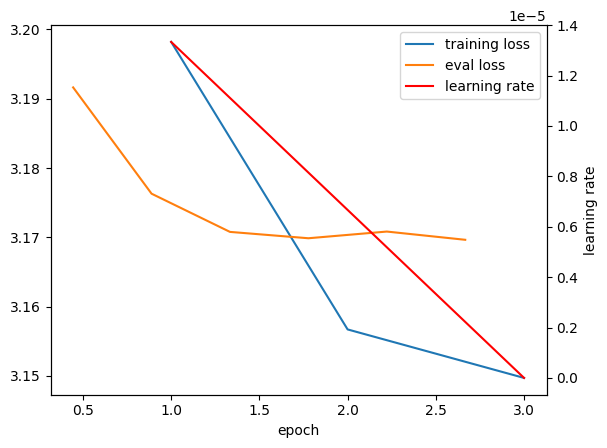

In [4]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

train_epoches = sorted(train_loss_record.keys())
train_values = [train_loss_record[k] for k in train_epoches]
ax1.plot(train_epoches, train_values, label="training loss")
eval_epoches = sorted(eval_loss_record.keys())
eval_values = [eval_loss_record[k] for k in eval_epoches]
ax1.plot(eval_epoches, eval_values, label="eval loss")
ax1.set_xlabel('epoch')
# ax1.legend()
h1, l1 = ax1.get_legend_handles_labels()
hc1 = [e.get_color() for e in h1]

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
lr_epoches = sorted(lr_record.keys())
lr_values = [lr_record[k] for k in lr_epoches]
ax2.set_ylabel('learning rate')
ax2.plot(lr_epoches, lr_values, label="learning rate", color='red')
# ax2.legend()
h2, l2 = ax2.get_legend_handles_labels()
hc2 = [e.get_color() for e in h2]

tmp, _ = ax2.get_legend_handles_labels()
tmp = tmp[0]

colors = hc1 + hc2
labels = l1 + l2
handles = [mlines.Line2D([], []) for _ in range(len(colors))]
for i, h in enumerate(handles):
    h.update_from(tmp)
    h.set_label(labels[i])
    h.set_color(colors[i])

plt.legend(handles, labels) # , bbox_to_anchor=(2.2, 0.5)) # , colors=['blue', 'orange', 'green', 'red'])

# plt.show()
plt.savefig("perceiver_mlm_contract_nli_2e_5_lr.png", bbox_inches = 'tight')

In [ ]:
## Graphics for run_61
import os
import json

run_dir = "../ignored_dir/training_outputs/perceiver_mlm/run_61"
latest_ckpt = max(os.listdir(run_dir), key=lambda x: int(x.split('-')[-1]))
latest_ckpt_path = os.path.join(run_dir, latest_ckpt)
json_path = os.path.join(latest_ckpt_path, "trainer_state.json")
print(f"reading from {json_path}")
with open(json_path) as f:
    json_f = json.load(f)
log_history = json_f['log_history']
train_loss_record, eval_loss_record, lr_record = dict(), dict(), dict()
for h in log_history:
    epoch = h['epoch']
    if "loss" in h:
        train_loss = h['loss']
        lr = h['learning_rate']
        train_loss_record[epoch] = train_loss
        lr_record[epoch] = lr
    else:
        eval_loss = h['eval_loss']
        eval_loss_record[epoch] = eval_loss

reading from ../ignored_dir/training_outputs/perceiver_mlm/run_61/checkpoint-2250/trainer_state.json


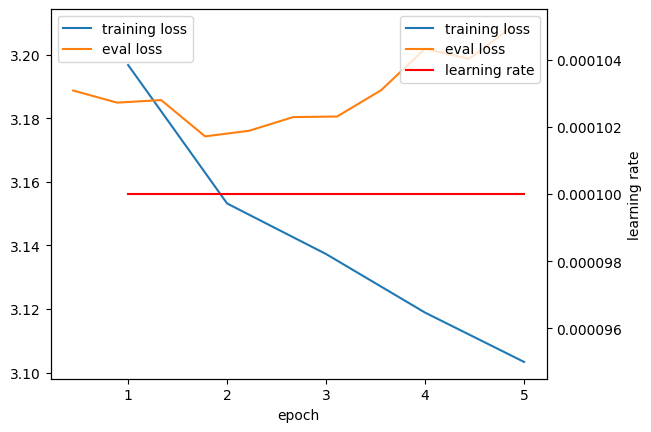

In [ ]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

train_epoches = sorted(train_loss_record.keys())
train_values = [train_loss_record[k] for k in train_epoches]
ax1.plot(train_epoches, train_values, label="training loss")
eval_epoches = sorted(eval_loss_record.keys())
eval_values = [eval_loss_record[k] for k in eval_epoches]
ax1.plot(eval_epoches, eval_values, label="eval loss")
ax1.set_xlabel('epoch')
ax1.legend()
h1, l1 = ax1.get_legend_handles_labels()
hc1 = [e.get_color() for e in h1]

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
lr_epoches = sorted(lr_record.keys())
lr_values = [lr_record[k] for k in lr_epoches]
ax2.set_ylabel('learning rate')
ax2.plot(lr_epoches, lr_values, label="learning rate", color='red')
ax2.legend()
h2, l2 = ax2.get_legend_handles_labels()
hc2 = [e.get_color() for e in h2]

tmp, _ = ax2.get_legend_handles_labels()
tmp = tmp[0]

colors = hc1 + hc2
labels = l1 + l2
handles = [mlines.Line2D([], []) for _ in range(len(colors))]
for i, h in enumerate(handles):
    h.update_from(tmp)
    h.set_label(labels[i])
    h.set_color(colors[i])

plt.legend(handles, labels) # , bbox_to_anchor=(2.2, 0.5)) # , colors=['blue', 'orange', 'green', 'red'])

# plt.show()
plt.savefig("perceiver_mlm_contract_nli_1e_4_lr.png", bbox_inches = 'tight')